# Klimadaten

Ist Grächen ein sicherer Wintersportort?

Wir verwenden Pandas um die Daten zu verarbeiten.

In [ ]:
%pip install pandas matplotlib statsmodels

Die Datenbank laden:

In [153]:
import pandas as pd

def read_csv(filename):
    # 1) Load CSV data and parse 'time' column as date with YYYYMMDD format.
    return pd.read_csv(filename, sep=';', parse_dates=['time'], date_format='%Y%m%d')

# Look at the data
df = read_csv('data/order_117249_data.txt')
df

,stn,time,tre200dx,tre200dn,hto000d0,tre200d0,rre150d0,hns000d0
0,GRC,1864-01-01,-,-,-,-5.5,0.0,-
1,GRC,1864-01-02,-,-,-,-11.6,0.7,-
2,GRC,1864-01-03,-,-,-,-16.6,0.0,-
3,GRC,1864-01-04,-,-,-,-6.2,0.0,-
4,GRC,1864-01-05,-,-,-,-6.9,0.0,-
...,...,...,...,...,...,...,...,...
58418,GRC,2023-12-11,4.5,-0.6,30,2.4,22.5,0
58419,GRC,2023-12-12,4.1,0.5,23,2.7,15.5,1
58420,GRC,2023-12-13,0.9,-1.9,19,-0.4,1.8,1
58421,GRC,2023-12-14,1.1,-3.3,20,-1.7,0.0,0


### Massage data to be in proper shape.

 * Rename 'hto000d0' column to 'snowheight'.
 * Only retain the interesting columns.
 * Drop rows with missing values for snowheight (-).
 * Convert snowheight column to numeric data instead of strings.
 * Extract a year column
   * Since we converted the 'time' column to be proper dates, we can simply use the datetime built-in.


In [154]:
def prepare_data(df):
    df = df.rename(columns={'hto000d0':'snowheight'})
    df = df[['time', 'snowheight']]
    df = df.loc[df['snowheight'] != '-']
    df.snowheight = pd.to_numeric(df.snowheight)

    df['year'] = df['time'].dt.year
    return df

# Look at the data
df = prepare_data(df)
df

,time,snowheight,year
37255,1966-01-01,80,1966
37256,1966-01-02,78,1966
37257,1966-01-03,83,1966
37258,1966-01-04,93,1966
37259,1966-01-05,88,1966
...,...,...,...
58418,2023-12-11,30,2023
58419,2023-12-12,23,2023
58420,2023-12-13,19,2023
58421,2023-12-14,20,2023


Compute a fresh dataset for the start of the snow-season:
* Group the daily values by year, then select the largest date (last day) for which there was zero snow.
* Note: Instead of zero, we could look for snowheight < some_limit.
* Drop the snowheight column.
* Rename the time column to describe what it contains.

We do the same for the end of the season, but look for the smallest (minimum) date.
Also, we need to decrement the year, to properly match it up with the season that started the previous year.

In [164]:
def compute_season_start(df, snow_limit=0):
    beginseason = df.loc[df['snowheight'] <= snow_limit].groupby(['year']).max()
    beginseason = beginseason.drop('snowheight', axis=1)
    beginseason = beginseason.rename(columns={'time': 'snowstart'})
    return beginseason

def compute_season_end(df, snow_limit=0):
    endseason = df.loc[df['snowheight'] <= snow_limit].groupby(['year']).min()
    endseason = endseason.drop('snowheight', axis=1)
    endseason = endseason.rename(columns={'time': 'snowend'})
    # We use the year of the season-start to identify a season - so we need to
    # decrement the year for season end to match it up with the season start.
    endseason.index -= 1
    return endseason

# The minimum snow cover in cm that we consider OK for skiing.
snow_limit = 0
graechen_begin_season = compute_season_start(df, snow_limit)
graechen_end_season = compute_season_end(df, snow_limit)
# Look at the data
graechen_end_season.tail(n=10)

,snowend
year,
2013,2014-03-21
2014,2015-03-19
2015,2016-01-01
2016,2017-01-01
2017,2018-04-14
2018,2019-02-28
2019,2020-02-24
2020,2021-03-01
2021,2022-03-01


#### Join begin and end
The 'year' column is the index of the grouped datasets, so join automatically selects it as join key.

An 'inner' join means we only produce a merged row if we find the key in both of the join partners. For example, the row for 2023 is omitted because there is no endseason value yet.

Also compute the length of the season in days: the difference between end and start, -1 as we measure from the first day with zero snow.

In [190]:
def compute_season_length(beginseason, endseason):
    seasons = beginseason.join(endseason, how='inner')
    seasons['season_duration_days'] = (seasons['snowend'] - seasons['snowstart']).dt.days - 1
    return seasons

graechen_seasons = compute_season_length(graechen_begin_season, graechen_end_season)
graechen_seasons.tail(n=10)

,snowstart,snowend,season_duration_days
year,,,
2013,2013-11-20,2014-03-21,120
2014,2014-12-26,2015-03-19,82
2015,2015-12-31,2016-01-01,0
2016,2016-12-31,2017-01-01,0
2017,2017-12-07,2018-04-14,127
2018,2018-12-07,2019-02-28,82
2019,2019-11-29,2020-02-24,86
2020,2020-12-01,2021-03-01,89
2021,2021-11-30,2022-03-01,90


#### Plotting

Plot the season length:

<Axes: xlabel='year'>

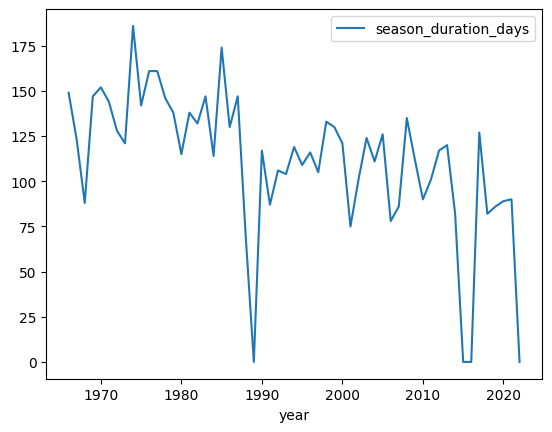

In [191]:
from matplotlib import pyplot
graechen_seasons.plot(y='season_duration_days')

#### Trend line
Compute a linear regression and add it to the graph.

Looks like statsmodels cannot regress on the index column, so re-add the year as a separate column 'x'.

<Axes: xlabel='year'>

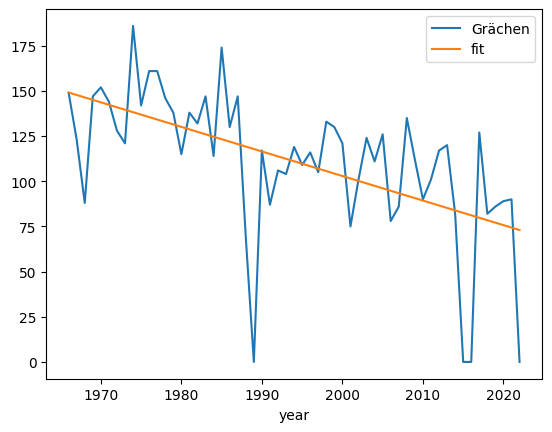

In [192]:
import statsmodels.api as sm

def add_regression(name, df):
    df['x'] = df.index
    model = sm.formula.gls(formula='season_duration_days ~ x', data=df)
    res = model.fit()
    df = df.assign(fit=res.fittedvalues)
    df = df[['season_duration_days', 'fit']]
    df = df.rename(columns={'season_duration_days': name})
    return df

graechen_seasons = add_regression("Grächen", graechen_seasons)
fig, ax = pyplot.subplots()
graechen_seasons.plot(ax=ax)



Dasselbe für Samedan:

<Axes: title={'center': 'Snow Season Length'}, xlabel='year', ylabel='Season Length (days)'>

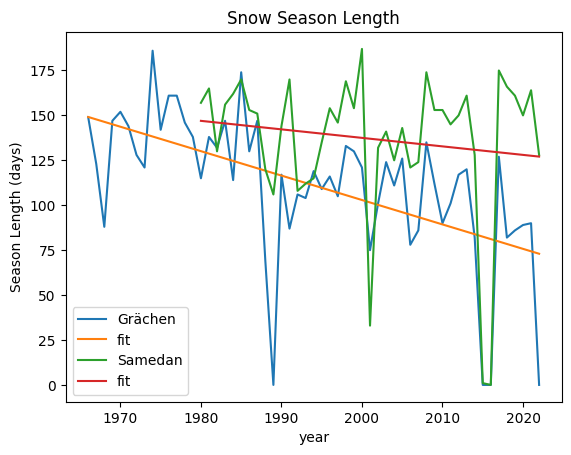

In [194]:
samedan = read_csv('data/order_117248_data.txt')
samedan = prepare_data(samedan)
samedan_seasons = compute_season_length(compute_season_start(samedan),
                                        compute_season_end(samedan))
samedan_seasons = add_regression("Samedan", samedan_seasons)

fig, ax = pyplot.subplots()
ax.set_xlabel("Year")
ax.set_ylabel("Season Length (days)")
ax.set_title("Snow Season Length")
graechen_seasons.plot(y=['Grächen', 'fit'], ax=ax)
samedan_seasons.plot(y=['Samedan', 'fit'], ax=ax)